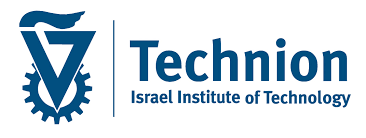

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/silviang10/silviang10/blob/master/tutorial4-Optimization.ipynb)

# Optimization
<img src="https://www.ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif"/>

In this tutorial, we will cover:

* Continuous Optimization
    + Solving continuous optimization problems
* Reminder: multivariate calculus
* Gradient Descent
    + Why does GD work?
    + Selecting the learning rate
    + What can go wrong?
* Stochastic gradient descent
* Advanced optimizers
* Working example
* PyTorch's optimization API - *torch.optim*
* Learning rate scheduling
* Projected Gradient Descent (PGD)
    + Use case: adversarial attacks

## Continuous Optimization

Continious optimization problems are fundumental in Computer Science.

May be either unconstrained:
$$ \min_x f(x) $$
$$ f: \mathbb{R}^d \rightarrow \mathbb{R} $$
Or constrained:
$$ \min_x f(x) \text{ subject to } x \in \mathcal{K} $$
$$ f: \mathbb{R}^d \rightarrow \mathbb{R} \text{, } \mathcal{K} \subseteq \mathbb{R}^d \text{ is closed and convex} $$

Many problems in CS can be written as a continous optimization problems:
* Linear programs (LPs)

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/3dpoly.svg/220px-3dpoly.svg.png"/></center>

* Linear Regression:

$$ \min_w \| Xw - y \|^2 $$
$$ \text{where } X \in \mathbb{R}^{n \times d}, y \in \mathbb{R}^n $$

* Hard SVMs:

$$ \min_{w,b} \|w\|^2 $$
$$ \text{subject to } y_i (w^T x_i-b) \geq 1 $$

* **Empirical risk minimization of deep models** 

<center><img src="https://www.fromthegenesis.com/wp-content/uploads/2018/06/Gradie_Desce.jpg"/></center>

### Solving Continious Optimization Problems

In some cases, continious optimization problems may be solved analytically:
* For unconstrained problems, search for stationary points.
* For constrained problems, try applying Lagrange multipliers or KKT conditions.

However, modern deep architectures include millions (sometimes billions) of parameters...
the loss function is summed over all the dataset (**memory burden**)
and the loss surface is often very noisy!

Therefore, efficient iterative optimization algorithms are required!

<center><img src="https://huggingface.co/blog/assets/33_large_language_models/01_model_size.jpg"/ width=40%> </center>

## Reminder: multivariate calculus

We will be mainly interested in functions $f: \mathbb{R}^d \rightarrow \mathbb{R}$.

The generalization of the derivative in the multivariate case is denoted as the **gradient**, which is composed of the **partial derivatives**:
$$ \nabla_x f = (\frac{\partial f}{\partial x_1},...,\frac{\partial f}{\partial x_d}) \in \mathbb{R}^d $$

The gradient gives us local information about the direction of the **largest ascent**:

<center><img src="https://github.com/silviang10/silviang10/blob/main/imgs/paraboloid.png?raw=1"/ height=70% width=70%> </center>

If the gradient at some point $x \in \mathbb{R}^d$ is $\vec{0}$ then $x$ is called a **stationary point**.

<!---
Redundant
For functions with multiple outputs $f: \mathbb{R}^d \rightarrow \mathbb{R^m}$ , the gradient is generalized to a **Jacobian**:

$$ J_x(f) = 
\begin{pmatrix}
            \frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_d} \\
            \vdots & \ddots & \vdots \\
            \frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_d} \\
        \end{pmatrix}
\in \mathbb{R}^{m \times d} $$
-->

The second derivative of a function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ is defined by computing the gradient of each of the partial derivatives.

The resulting matrix is defined as the **Hessian** of $f$:
$$
\nabla^2_x f = 
\begin{pmatrix}
            \frac{\partial^2 f}{\partial x_1 \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_d} \\
            \vdots & \ddots & \vdots \\
            \frac{\partial^2 f}{\partial x_d \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_d \partial x_d} \\
        \end{pmatrix}
\in \mathbb{R}^{d \times d} $$

## Gradient Descent

* Iterative algorithm for solving continious optimization problems.
* Exploit local information from the current guess to produce the next guess.
* Idea: move along the anti-gradient direction of the currrent guess:

$$ x_{k+1} = x_k - \eta \nabla_x f (x_k) $$

We denote $ \eta $, which determines the step size as the **learning rate**.

### Why does GD work?

By using first order Taylor's approximation around $x_k$:
$$ f(x_k + \delta) = f(x_k) + \nabla_x f(x_k)^T \delta + o(\| \delta\|)$$
Substituting $\delta = - \eta \nabla_x f (x_k)$:
$$ f(x_{k+1}) = f(x_k) - \eta \| \nabla_x f(x_k) \|^2 + o(\| \delta\|)$$
If $x_k$ is not a stationary point, then for a small enough $\eta > 0 $ we have that $f$ strictly decreases.
This however **does not prove** that GD converges to a local minimum, but rather gives a motivation.
The convergence analysis of GD is given in: https://courses.cs.washington.edu/courses/cse546/15au/lectures/lecture09_optimization.pdf.

### Selecting the learning rate

* Selecting the right learning rate is very important!
* Selecting too small learning rate would yield to a very slow optimization process ("**under-damped**").
* Selecting too large learning rate would yield to a jumpy process ("**over-damped**").
* Selecting a very large learning rate would cause the optimization process to diverge!

<center><img src="https://github.com/silviang10/silviang10/blob/main/imgs/lr.gif?raw=1"> </center>

* What is the optimal learning rate?
* For quadratic objectives, $\eta_{opt} = \frac{1}{\lambda_{max}}$ where $\lambda_{max}$ is the largest eigenvalue of the (constant) hessian matrix.
* For general objectives, computing $\lambda_{max}$ in every iteration is hard.
* In practice: perform manual or black-box tuning.
* Check out [optuna](https://optuna.org/).

### What can go wrong?

<center> <img src="https://nbviewer.org/github/vistalab-technion/cs236781-tutorials/blob/master/t01%20-%20linear%20models/imgs/sgd2d_2.png" height=40%, width=40%%> </center>

* The loss surface of DNNs is highly non-convex!
* GD depends on initialization. May converge to a **local minimum** rather than a **global minimum**!
* Another issue with GD is that it considers all the samples together (memory and computation burdens)!

## Stochastic Gradient Descent

* In our case the optimization objective can be decomposed as a sum (mean) of objectives on each sample:
$$ f(x) = \frac{1}{n} \sum_{i=1}^n f_i(x) $$
* Recall that $n$ is very large.
* Idea: sample an index, and compute the gradient on a single datum:
$$ i \leftarrow Uniform(\{1,...,n\}) $$
$$ x_{k+1} \leftarrow x_k - \eta \nabla f_i(x_k)$$
* In expectation the gradient is exact! However, the variance is very high!
* Optimization process becomes very noisy!

* Idea: instead of sampling a single datum, sample a **batch(mini-batch)** of samples.
* In practice: shuffle the dataset and split it into **mini-batches**. Each iteration over the whole dataset is called an **epoch**.


<center>
<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/batch-1-1024x670.png" width=35% >
</center>

## Advanced optimizers

* Heavy ball momentum
    + Idea: accumulate velocity from prior iterations!
    + Models the physics of a ball that is rolling downhill.
    <center>
    <img src="https://miro.medium.com/v2/resize:fit:640/1*zVi4ayX9u0MQQwa90CnxVg.gif">
    </center>
    
    + Momentum is modeled by an exponential moving average of the gradients in the prior steps:
    
  $$ v_{k+1} \leftarrow \gamma v_k + (1-\gamma) g_k $$
  $$ x_{k+1} \leftarrow x_k - \eta v_{k+1} $$


* AdaGrad
    + Stands for Adaptive Gradient.
    + Idea: the Hessian matrix may be very unbalanced, so use different effective learning rate for each parameter.
    <center>
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*WRtvrr9Z0QcokiKlgU7xEw.gif" width=40%>
    </center>
    
    + Mathematically: 
  $$ G_{k+1} \leftarrow G_k + g_k \cdot g_k $$
  $$ x_{k+1} \leftarrow x_k - \frac{\eta}{\sqrt{G_{k+1} + \epsilon}} \cdot g_k $$

    + Note that in the above formulation $\cdot$ multiplication and the division is done **elementwise**.
    + $\epsilon$ is added to the denominator for numerical stability.


* Rmsprop
    + The problem of Adagrad is that the denominator keeps growing, and hence becomes very slow.
    + The solution is to use an EMA of the squared gradients instead:

  $$ v_{k+1} \leftarrow \beta v_k + (1-\beta) g_k \cdot g_k $$
  $$ x_{k+1} \leftarrow x_k - \frac{\eta}{\sqrt{v_{k+1} + \epsilon}} \cdot g_k $$

    <center>
    <img src="https://miro.medium.com/v2/resize:fit:640/1*_4zyVpZazh4OSIzprmYQEw.gif" width=40%>
    </center>

* Adam
    + Stands for Adaptive Moment Estimation.
    + Essentially a combination of momentum and rmsprop:
  $$ m_{k+1} \leftarrow \beta_1 m_k + (1-\beta_1) g_k $$
  $$ v_{k+1} \leftarrow \beta_2 v_k + (1-\beta_2) g_k \cdot g_k $$
  $$ \hat{m}_{k+1} \leftarrow \frac{m_{k+1}}{1-\beta_1^{k+1}}, \quad \hat{v}_{k+1} \leftarrow \frac{v_{k+1}}{1-\beta_2^{k+1}} $$
  $$ x_{k+1} \leftarrow x_k - \frac{\eta}{\sqrt{\hat{v}_{k+1} + \epsilon}} \cdot \hat{m}_{k+1} $$
    + The most common optimizer today.

* Which optimizer to use?
    + Adam would be a good place to start.
    + However, **for some tasks it is better to use other optimizers**.
    + For instance, simple SGD with momentum works the best for optimizing ResNet!

## Working example

Let's demonstrate SGD for training a simple MLP architecture for performing hand-written digit recognition.

In [ ]:
# Imports
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# Define an MLP architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.in_dim = 784
        self.hidden_dim = 120
        self.out_dim = 10

        self.flatten = nn.Flatten() # (B,H,W) -> (B,D)
        self.linear = nn.Linear(self.in_dim, self.hidden_dim)
        self.activation = nn.ReLU()
        self.classifier = nn.Linear(self.hidden_dim, self.out_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.activation(x)
        x = self.classifier(x)
        return x
    
model = Net() # Instantiate model

In [ ]:
# Define the training dataset
transform = transforms.Compose([
            transforms.ToTensor(), # Convert to tensor
            transforms.Normalize((0.1307,), (0.3081,)) # Subtract from values 0.13 then divide by 0.31
            ])

dataset = datasets.MNIST('./data', train=True, download=True, transform=transform) # MNIST train set

100%|██████████| 9912422/9912422 [00:00<00:00, 221666193.45it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 91769465.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72276185.86it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5110120.38it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define dataloader 
batch_size = 64
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) # Different order in each epoch

On each batch, optimization can be summarized as follows:
* Loss computation on the current batch.
* Loss gradient computation w.r.t each of the model params.
* perfrom SGD step.

In [ ]:
# Actual Training loop
num_epochs = 1
lr = 1e-1
loss_fn = nn.CrossEntropyLoss()
losses = [] # For plotting

model.train() # Training mode
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(loader):

        # 1. Compute loss    
        logits = model(x)
        loss = loss_fn(logits, y)

        # 2. Magically compute gradient
        grad = torch.autograd.grad(loss, model.parameters())

        # 3. Perform optimization step
        for param, g in zip(model.parameters(), grad):
            param.grad = g
            param.data -= lr * param.grad

        losses.append(loss.item())

Lets plot the loss over time!

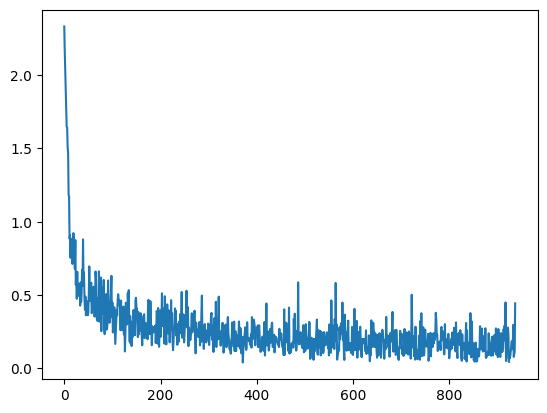

In [ ]:
plt.plot(losses)

Let's see what happens when we decrease the batch size!

In [ ]:
# This time, let's try with a smaller batch size!

model = Net() # re-initialize net

# re-define dataloader 
batch_size = 16
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Actual Training loop
num_epochs = 1
lr = 1e-1
loss_fn = nn.CrossEntropyLoss()
losses = [] # For plotting

In [ ]:
model.train() # Training mode
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(loader):
        
        # 1. Compute loss    
        logits = model(x)
        loss = loss_fn(logits, y)
        # 2. Magically compute gradient
        grad = torch.autograd.grad(loss, model.parameters())
        # 3. Perform optimization step
        for param, g in zip(model.parameters(), grad):
            param.grad = g
            param.data -= lr * param.grad
            
        losses.append(loss.item())

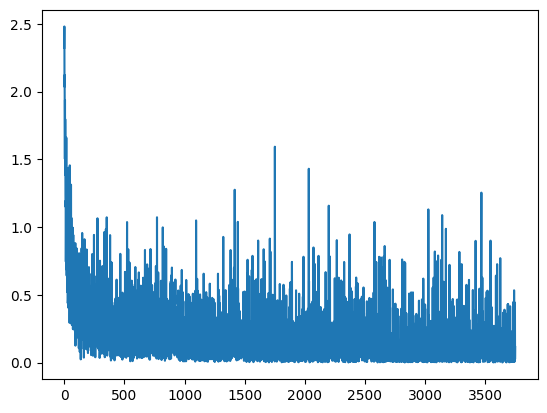

In [ ]:
plt.plot(losses)

As we can observe, smaller batch yields to a more noisy optimization process.
This is due to high gradient variance!

## PyTorch's optimization API - *torch.optim*

* For performing optimization with ease, PyTorch includes an optimization interface named torch.optim.
* Supports numerous optimization algorithms!
* We will demonstrate the API by replacing the above training procedure. 

In [ ]:
from torch.optim import SGD

In [ ]:
model = Net() # re-initialize net
batch_size = 64
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) # re-define dataloader 

# define the optimizer
optimizer = SGD(model.parameters(), lr=lr)

model.train()
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(loader):

        # compute loss    
        logits = model(x)
        loss = loss_fn(logits, y)

        # The three Musketeers!
        optimizer.zero_grad() # sets p.grad = 0 for all params
        loss.backward() # sets p.grad += dloss/dp
        optimizer.step() # performs actual optimization step

## Learning rate scheduling

* Observation: loss surface drastically changes over time and so is the hessian.
* Idea: change the learning rate over time.
* The most common practice is to reduce the learning rate after few epochs.
* Very useful in practice.
* Schedulers are also supported by torch.optim library!

<center>
<img src="https://github.com/silviang10/silviang10/blob/main/imgs/scheduler.png?raw=1" width=40%, height=40%>
<center>

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
model = Net()
num_epochs = 2

# define the optimizer and the scheduler
optimizer = SGD(model.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer, milestones=[1], gamma=0.1) # reduce lr by 0.1 after 1 epoch

model.train()
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(loader):

        # compute loss    
        logits = model(x)
        loss = loss_fn(logits, y)

        # The three Musketeers!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 300 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] | Batch {batch_idx+1} | \
loss: {loss.item():.4f} | lr: {optimizer.param_groups[0]["lr"]:.4f}')
        losses.append(loss.item())

    # Inform the scheduler an epoch was done!
    scheduler.step()

Epoch [1/2] | Batch 300 | loss: 0.2614 | lr: 0.1000
Epoch [1/2] | Batch 600 | loss: 0.2048 | lr: 0.1000
Epoch [1/2] | Batch 900 | loss: 0.1132 | lr: 0.1000
Epoch [2/2] | Batch 300 | loss: 0.1388 | lr: 0.0100
Epoch [2/2] | Batch 600 | loss: 0.1058 | lr: 0.0100
Epoch [2/2] | Batch 900 | loss: 0.1069 | lr: 0.0100


Additional learning rate scheduling strategies include:
* Cosine annealing:
<center>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*9hiywbEuoVXz4iX2-BDGZQ.png" width=30%>
</center>

* Learning rate warmup:
<center>
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/warmup_cosine_schedule.png">
</center>

## Projected Gradient Descent (PGD)

* So far, we have been concerned with **unconstrained** optimization problems.
* However, all of the above optimization algorithms may be generalized to **constrained** optimization problem of the following form:

$$ \min_x f(x) \text{ subject to } x \in \mathcal{K} $$
$$ f: \mathbb{R}^d \rightarrow \mathbb{R} \text{, } \mathcal{K} \subseteq \mathbb{R}^d \text{ is closed and convex} $$

* This is done by a simple-greedy agorithm named PGD.
* The idea is to project $x$ onto $\mathcal{K}$ after each iteration:
$$ \tilde{x}_{k+1} = x_k - \eta \nabla_x f (x_k) $$
$$ x_{k+1} = \Pi_\mathcal{K}(\tilde{x}_{k+1})$$
* The algorithm can be proved to converge under the same conditions required for GD to converge!

<center>
<img src="https://qph.cf2.quoracdn.net/main-qimg-8311c35651e61b7b91e8918388946469">
</center>

* Mathematically, the projection of a point onto a set is defined as the closest point to the original point within the set:
$$ \Pi_{\mathcal{K}}(x) := \arg \min_y \| y-x \| \text{ subject to } y \in \mathcal{K}$$

* Common projections:
    + A canonical sphere with radius $R$:
    $$ \Pi_{\mathcal{B}(R)}(x) = \min\{\frac{R}{\| x \|}, 1\} \cdot x $$
    <center>
    <img src="http://pi.math.cornell.edu/~dwh/books/eg99/Ch16/37850c60.jpg" width=30%>
    </center>
    
    + A linear subspace $W$:
    $$ \Pi_{W}(x) = \sum_{i=1}^m \langle x , \; w_i \rangle w_i $$
    where $\{ w_1, ..., w_m\}$ is an orthonormal basis for $W$.

    <center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png" width=25%
    </center>

### Use case: adversarial attacks

* The goal is to find a small perturbation on a certain input, in a way which would cause the model to generate a wrong prediction.

<center>
<img src="https://i.stack.imgur.com/5rfe9.png">
</center>

* Let's carry a PGD attack on a sample from the test dataset with respect to our trained model!

In [ ]:
# Define the test dataset
transform = transforms.Compose([
            transforms.ToTensor(), # Convert to tensor
            transforms.Normalize((0.1307,), (0.3081,)) # Subtract 0.13 then divide by 0.31
            ])

# MNIST test set
dataset = datasets.MNIST('./data', train=False, download=True, transform=transform) 
sample_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
sample, true_y = next(iter(sample_loader))
sample = sample.detach()

Text(0.5, 1.0, 'Ground Truth: 7\nPrediction: 7, confidence: 99.84%')

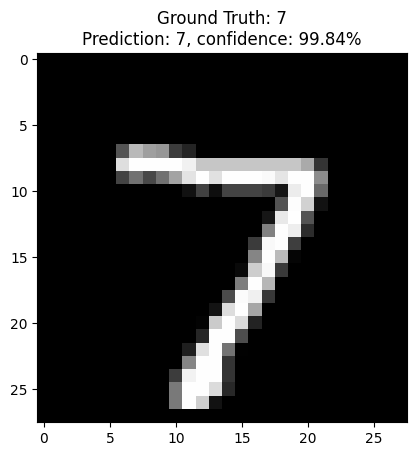

In [ ]:
# Visualize the sample
with torch.no_grad():
    logit = model(sample)[0]
    proba = torch.softmax(logit, dim=0)
    pred = torch.argmax(proba)

fig = plt.figure()
plt.imshow(sample.reshape(28,28), cmap='gray', interpolation='none')
plt.title("Ground Truth: {}\nPrediction: {}, confidence: {:.2f}%". \
          format(true_y.item(), pred, proba[pred]*100))

In [ ]:
attacked_sample = sample.clone()
attacked_sample.requires_grad = True
# maximize loss instead of minimizing it!
adversarial_optimizer = SGD([attacked_sample], lr=1e-1, maximize=True)
eps = 7
n_iters = 10_000
loss_fn = nn.CrossEntropyLoss()

for iter_idx in range(n_iters):
    logits = model(attacked_sample)
    loss = loss_fn(logits, true_y)

    # Gradient step
    adversarial_optimizer.zero_grad()
    loss.backward()
    adversarial_optimizer.step()

    # Projection!
    delta = attacked_sample.data - sample.data
    delta *= min(1,eps/torch.norm(delta))
    attacked_sample.data = sample + delta

    if (iter_idx + 1) % 1000 == 0:
        print(f'Iteration [{iter_idx+1}] | loss: {loss.item():.4f}')

Iteration [1000] | loss: 0.0028
Iteration [2000] | loss: 0.0168
Iteration [3000] | loss: 7.0017
Iteration [4000] | loss: 7.0019
Iteration [5000] | loss: 7.0012
Iteration [6000] | loss: 7.0029
Iteration [7000] | loss: 7.0029
Iteration [8000] | loss: 7.0023
Iteration [9000] | loss: 7.0026
Iteration [10000] | loss: 7.0021


Text(0.5, 1.0, 'Ground Truth: 7\nPrediction: 3, confidence: 99.56%')

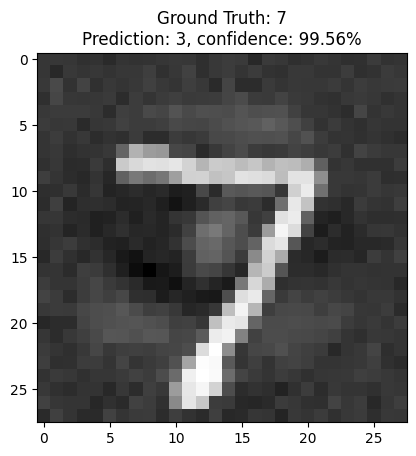

In [ ]:
# Visualize the attacked sample

with torch.no_grad():
    logit = model(attacked_sample)[0]
    proba = torch.softmax(logit, dim=0)
    pred = torch.argmax(proba)

fig = plt.figure()
plt.imshow(attacked_sample.detach().numpy().reshape(28,28), cmap='gray', interpolation='none')
plt.title("Ground Truth: {}\nPrediction: {}, confidence: {:.2f}%" \
          .format(true_y.item(), pred, proba[pred]*100))

* As can be observed the model mistakes with very high confidence on the perturbated sample.
* However, it is clear that the ground truth is still the same!

## Credits

* This tutorial was written by Mitchell Keren Taraday.
* Image credits:
    + [https://www.ruder.io/optimizing-gradient-descent/](https://www.ruder.io/optimizing-gradient-descent/)
    + [https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/3dpoly.svg/1024px-3dpoly.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/3dpoly.svg/1024px-3dpoly.svg.png)
    + [https://www.fromthegenesis.com/gradient-descent-part1/](https://www.fromthegenesis.com/gradient-descent-part1/)
    + [https://huggingface.co/blog/assets/33_large_language_models/01_model_size.jpg](https://huggingface.co/blog/assets/33_large_language_models/01_model_size.jpg)
    + [https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/batch-1-1024x670.png](https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/batch-1-1024x670.png)
    + [https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c)
    + [https://www.researchgate.net/publication/332709751_Data-Driven_Neuron_Allocation_for_Scale_Aggregation_Networks](https://www.researchgate.net/publication/332709751_Data-Driven_Neuron_Allocation_for_Scale_Aggregation_Networks)
    + [https://towardsdatascience.com/the-best-learning-rate-schedules-6b7b9fb72565](https://towardsdatascience.com/the-best-learning-rate-schedules-6b7b9fb72565)
    + [https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/warmup_cosine_schedule.png](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/warmup_cosine_schedule.png)
    + [https://home.ttic.edu/~nati/Teaching/TTIC31070/2015/Lecture16.pdf](https://home.ttic.edu/~nati/Teaching/TTIC31070/2015/Lecture16.pdf)
    + [https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png](https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png)
    + [https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png](https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Linalg_projection_onto_plane.png/223px-Linalg_projection_onto_plane.png)
    + [https://i.stack.imgur.com/5rfe9.png](https://i.stack.imgur.com/5rfe9.png)
    + [http://www.cohennadav.com/files/icermw19_slides.pdf](http://www.cohennadav.com/files/icermw19_slides.pdf)